**Name:** ZHAI Qiuyu

**EID:** 59991830

# CS5489 - Tutorial 1
## Text Document Classification with Naive Bayes

In this tutorial you will classify text documents using Naive Bayes classifers.  We will be working with the dataset called "20 Newsgroups", which is a collection of 20,000 newsgroup posts organized into 20 categories.

First we need to initialize Python.  Run the below cell.

In [ ]:
# 设置matplotlib在Jupyter环境中内嵌显示图表
%matplotlib inline

# 导入matplotlib_inline模块，用于配置输出图像格式
import matplotlib_inline   

# 将matplotlib的输出图像格式设置为SVG（矢量图格式，清晰度更高）
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# 导入matplotlib的pyplot模块，用于绘制图表
import matplotlib.pyplot as plt

# 导入matplotlib主模块，可用于更高级的配置
import matplotlib

# 从numpy库导入所有函数和类（不推荐在实际项目中使用这种方式）
from numpy import *

# 从sklearn（scikit-learn）库导入所有函数和类（不推荐在实际项目中使用这种方式）
from sklearn import *

# 从scipy库导入stats（统计函数）和special（特殊数学函数）模块，是Numpy的高级版
from scipy import stats, special

# 设置随机数种子为100，确保实验结果可重现
random.seed(100)

Next, put the file "20news-bydate_py3.pkz' into the same directory as this ipynb file. **Do not unzip the file.**

Next, we will extract 4 classes from the dataset.  Run the below cell.

In [ ]:
# 定义需要从文本中移除的部分集合：标题、页脚和引用内容
# 这些部分通常不包含正文信息，移除后可以提高模型训练效果
removeset = ('headers', 'footers', 'quotes')

# 定义我们只使用的4个新闻类别
cats      = ['alt.atheism',         # 关于无神论的讨论
             'talk.religion.misc',  # 关于宗教的 miscellaneous 讨论
             'comp.graphics',       # 关于计算机图形学的讨论
             'sci.space']           # 关于太空科学的讨论

# 加载训练数据集
# subset='train' 表示加载训练集
# remove=removeset 表示移除指定的内容（标题、页脚、引用）
# categories=cats 表示只加载指定的4个类别
# data_home='./' 表示数据存储在当前目录下
newsgroups_train = datasets.fetch_20newsgroups(subset='train',
                           remove=removeset, categories=cats, data_home='./')

# 加载测试数据集
# 与训练集参数类似，subset='test' 表示加载测试集
newsgroups_test  = datasets.fetch_20newsgroups(subset='test', 
                           remove=removeset, categories=cats, data_home='./')

Now, we check if we got all the data.  The training set should have 2034 documents, and the test set should have 1353 documents.

In [ ]:
# 显示数据集对象的类型
print("数据集对象类型：", type(newsgroups_train))
print("\n----------------------------------------")

# 查看数据集包含的所有属性
print("数据集包含的属性：", dir(newsgroups_train))
print("\n----------------------------------------")

# 查看第1篇文本的类别：target标签的索引（0，1，2，3中的一个数） → target_names名称（标签的具体名称）
print(f"第1篇文本的类别索引：{newsgroups_train.target[0]}")
print(f"对应的类别名称：{newsgroups_train.target_names[newsgroups_train.target[0]]}")

数据集对象类型： <class 'sklearn.utils._bunch.Bunch'>

----------------------------------------
数据集包含的属性： ['DESCR', 'data', 'filenames', 'target', 'target_names']

----------------------------------------
第1篇文本的类别索引：1
对应的类别名称：comp.graphics


In [ ]:
print("training set size:", len(newsgroups_train.data))
print("testing set size: ",  len(newsgroups_test.data))
print(newsgroups_train.target_names)

training set size: 2034
testing set size:  1353
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [ ]:
#看看训练集里不同类别的文本都有多少
print("class counts")
for i in [0, 1, 2, 3]:
    print("{:20s}: {}".format(newsgroups_train.target_names[i], sum(newsgroups_train.target == i)))

class counts
alt.atheism         : 480
comp.graphics       : 584
sci.space           : 593
talk.religion.misc  : 377


Now have a look at the documents.  `newsgroups_train.data` is a list of strings, and `newsgroups_train.data[i]` is the i-th document.

In [ ]:
for i in [0, 1, 2 ,3]:
    print("--- document {} (class={}) ---".format(
        i, newsgroups_train.target_names[newsgroups_train.target[i]]))
    print(newsgroups_train.data[i])

--- document 0 (class=comp.graphics) ---
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
--- document 1 (class=talk.religion.misc) ---


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil 

**Tip:** while you do the tutorial, it is okay to make additional code cells in the file.  This will allow you to avoid re-running code (like training a classifier, then testing a classifier).

### Build document vectors
Create the vocabulary from the training data.  Then build the document vectors for the training and testing sets.  You can decide how many words you want in the vocabulary.

词汇表（vocabulary） 是从训练文本中提取的所有不重复单词的集合，是 token 集（token set）在文本处理场景下的具体体现

In [ ]:
# 从训练数据集中提取文档内容（文本数据）
# traindata 是一个列表，每个元素是一篇新闻文档的文本内容
traindata = newsgroups_train.data

# 从训练数据集中提取对应的标签（类别）
# trainY 是一个数组，每个元素是对应文档的类别索引（与 cats 列表中的类别对应）
trainY = newsgroups_train.target

# 从测试数据集中提取文档内容（文本数据）
# testdata 是一个列表，每个元素是一篇新闻文档的文本内容
testdata = newsgroups_test.data

# 从测试数据集中提取对应的标签（类别）
# testY 是一个数组，每个元素是对应文档的类别索引（与 cats 列表中的类别对应）
testY  = newsgroups_test.target

In [ ]:
### INSERT YOUR CODE HERE

In [ ]:
#词汇表生成简易版代码
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=100)

trainX = cntvect.fit_transform(traindata)

testX  = cntvect.transform(testdata)

# 查看特征形状
print(f"训练集特征形状: {trainX.shape}")
print(f"测试集特征形状: {testX.shape}")

训练集特征形状: (2034, 100)
测试集特征形状: (1353, 100)


In [ ]:
print(trainX[0])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 10 stored elements and shape (1, 100)>
  Coords	Values
  (0, 92)	1
  (0, 27)	6
  (0, 19)	2
  (0, 44)	1
  (0, 40)	2
  (0, 72)	1
  (0, 47)	1
  (0, 66)	1
  (0, 29)	2
  (0, 4)	1


###  Bernoulli Naive Bayes 
Learn a Bernoulli Naive Bayes model from the training set.  What is the prediction accuracy on the test set?  Try different parameters (alpha, max_features, etc) to get the best performance.

In [ ]:
from sklearn.naive_bayes import BernoulliNB
### INSERT YOUR CODE HERE
#用伯努利是因为特征数据（即二维矩阵）是0或1
#创建伯努利朴素贝叶斯模型和训练（自动贝叶斯定理的过程：每个类别下的先验概率->每个特征的似然概率->相乘比大小）
bmodel=BernoulliNB()
#bnb.fit接受（二维矩阵，一维数组）
bmodel.fit(trainX,trainY)

BernoulliNB()

In [ ]:
import numpy as np
np.exp(bmodel.class_log_prior_)

array([0.2359882 , 0.28711898, 0.29154376, 0.18534907])

In [ ]:
from sklearn.metrics import accuracy_score
testY_pred=bmodel.predict(testX)
accuracy=accuracy_score(testY,testY_pred)
accuracy

0.5838876570583887

In [ ]:
#试试别的参数
bmodel2 = BernoulliNB(alpha=2.0)
bmodel2.fit(trainX,trainY)
testY_pred=bmodel2.predict(testX)
accuracy=accuracy_score(testY,testY_pred)
accuracy

0.5831485587583148

What are the most important (frequent) words for each category?  Run the below code.

Note: `model.feature_log_prob_[i]` will index the word log-probabilities for the i-th class

In [ ]:
# 获取所有特征词（词汇表）并转换为数组
# cntvect是文本向量化器（如CountVectorizer），get_feature_names_out()返回所有特征词
fnames = asarray(cntvect.get_feature_names_out())
# 返回的是一个 numpy 数组
# 示例：array(['apple', 'banana', 'orange'], dtype=object)

# 遍历数据集中的每个类别
# enumerate()返回索引i和类别名称c
# newsgroups_train.target_names是所有类别的名称列表
for i, c in enumerate(newsgroups_train.target_names):
    # bmodel是训练好的朴素贝叶斯模型，feature_log_prob_[i]存储第i类的词概率的对数值
    # argsort()返回排序后的索引（从小到大），[-10:]取最后10个
    tmp = argsort(bmodel.feature_log_prob_[i])[-10:]
    
    # 打印当前类别名称
    print("class", c)
    
    # 遍历这10个高频词的索引
    for t in tmp:
        # 打印词语及其在当前类别中的对数概率
        # fnames[t]通过索引获取词语，bmodel.feature_log_prob_[i][t]获取对应概率值
        # {:9s}控制字符串宽度为9，{:.5f}控制浮点数保留5位小数
        print("    {:9s} ({:.5f})".format(fnames[t], bmodel.feature_log_prob_[i][t]))#这里加个对数表示就好看很多

class alt.atheism
    time      (-1.79592)
    does      (-1.60323)
    know      (-1.60323)
    god       (-1.58282)
    like      (-1.54322)
    say       (-1.52398)
    just      (-1.45056)
    think     (-1.39045)
    people    (-1.29514)
    don       (-1.18751)
class comp.graphics
    just      (-1.94250)
    don       (-1.90741)
    program   (-1.87351)
    need      (-1.85153)
    does      (-1.73859)
    use       (-1.72893)
    like      (-1.60264)
    know      (-1.50579)
    graphics  (-1.49052)
    thanks    (-1.46805)
class sci.space
    earth     (-1.89993)
    use       (-1.87770)
    time      (-1.76359)
    know      (-1.72512)
    think     (-1.72512)
    nasa      (-1.72512)
    don       (-1.68808)
    just      (-1.46858)
    like      (-1.41183)
    space     (-1.01792)
class talk.religion.misc
    say       (-1.64708)
    way       (-1.62005)
    like      (-1.60680)
    does      (-1.53082)
    know      (-1.48319)
    think     (-1.41575)
    god       (-1.373

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mmodel = MultinomialNB()
mmodel.fit(trainX, trainY)

MultinomialNB()

In [ ]:
predY= mmodel.predict(testX)
accuracy=accuracy_score(testY,predY)
accuracy

0.6178861788617886

In [ ]:
# get the word names
fnames = asarray(cntvect.get_feature_names_out())
for i,c in enumerate(newsgroups_train.target_names):
    tmp = argsort(mmodel.feature_log_prob_[i])[-10:]
    print("class", c)
    for t in tmp:
        print("    {:9s} ({:.5f})".format(fnames[t], mmodel.feature_log_prob_[i][t]))

class alt.atheism
    like      (-3.76448)
    believe   (-3.75836)
    say       (-3.69344)
    atheism   (-3.55991)
    does      (-3.52069)
    just      (-3.51112)
    think     (-3.48295)
    don       (-3.28607)
    people    (-3.05611)
    god       (-2.85187)
class comp.graphics
    software  (-3.78056)
    images    (-3.78056)
    files     (-3.75735)
    data      (-3.74822)
    use       (-3.72131)
    file      (-3.55835)
    jpeg      (-3.55086)
    edu       (-3.44475)
    graphics  (-3.12325)
    image     (-2.95770)
class sci.space
    just      (-3.86316)
    shuttle   (-3.84750)
    time      (-3.82192)
    orbit     (-3.80192)
    data      (-3.73029)
    earth     (-3.70302)
    like      (-3.70302)
    launch    (-3.51920)
    nasa      (-3.18326)
    space     (-2.21248)
class talk.religion.misc
    say       (-3.62948)
    know      (-3.62948)
    christian (-3.61624)
    think     (-3.61624)
    just      (-3.56494)
    bible     (-3.55871)
    don       (-3.546

### Multinomial Naive Bayes model
Now learn a multinomial Naive Bayes model using the TF-IDF representation for the documents.  Again try different parameter values to improve the test accuracy.

In [ ]:
### INSERT YOUR CODE HERE

In [ ]:
#生成TF-IDF特征
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvect = TfidfVectorizer(
    stop_words='english', 
    max_features=100
)
trainX_tf= tfidfvect.fit_transform(traindata)  # 训练集TF-IDF特征
testX_tf = tfidfvect.transform(testdata)        # 测试集TF-IDF特征

In [ ]:
trainX_tf.shape

(2034, 100)

In [ ]:
#训练模型
mmodel_tf = MultinomialNB()
mmodel_tf.fit(trainX_tf, trainY)
predY_tf = mmodel_tf.predict(testX_tf)
accuracy=accuracy_score(testY,predY_tf)
accuracy

NameError: name 'model_tf' is not defined

What are the most important features for Multinomial model? Run the below code.

In [ ]:
# get the word names
fnames = asarray(cntvect.get_feature_names_out())
for i,c in enumerate(newsgroups_train.target_names):
    tmp = argsort(mmodel_tf.feature_log_prob_[i])[-10:]
    print("class", c)
    for t in tmp:
        print("    {:9s} ({:.5f})".format(fnames[t], mmodel_tf.feature_log_prob_[i][t]))

class alt.atheism
    atheism   (-3.88650)
    know      (-3.80127)
    religion  (-3.74619)
    does      (-3.69588)
    say       (-3.59682)
    just      (-3.56356)
    think     (-3.39604)
    don       (-3.32402)
    people    (-3.26848)
    god       (-3.20057)
class comp.graphics
    like      (-3.85247)
    use       (-3.80096)
    program   (-3.76665)
    does      (-3.72727)
    file      (-3.71102)
    files     (-3.67706)
    image     (-3.64685)
    know      (-3.63577)
    thanks    (-3.33411)
    graphics  (-3.12267)
class sci.space
    time      (-4.00408)
    earth     (-3.93269)
    don       (-3.93033)
    launch    (-3.89591)
    think     (-3.88835)
    orbit     (-3.75640)
    just      (-3.65351)
    nasa      (-3.57892)
    like      (-3.53593)
    space     (-2.71415)
class talk.religion.misc
    say       (-3.81805)
    did       (-3.81545)
    know      (-3.71242)
    think     (-3.70414)
    just      (-3.65161)
    don       (-3.64550)
    christian (-3.627

How do the most important words differ between the TF-IDF multinomial model and the Bernoulli model?

- **INSERT YOUR ANSWER HERE**

Finally, look at a few of the misclassified documents. 

In [ ]:
### INSERT YOUR CODE HERE ###

In [ ]:
#遍历来看看
misclassified_indices = []
for i in range(len(testY)):
    if testY[i] != predY_tf[i]:
        misclassified_indices.append(i)

In [ ]:
count=len(misclassified_indices)
count

503

Can you get any intuition or reason why they were misclassified?

- **INSERT YOUR ANSWER HERE**
- 分错的这些文档可能包含多个类别的混合信息

### Effect of smoothing
The smoothing (regularization) parameter has a big effect on the performance.  Using the Multinomial TF-IDF models, make a plot of accuracy versus different values of alpha. For each alpha, you need to train a new model. Which alpha value yields the best result?

In [ ]:
### INSERT YOUR CODE HERE

alpha = 0.001, 精度 = 0.6282
alpha = 0.010, 精度 = 0.6275
alpha = 0.100, 精度 = 0.6305
alpha = 1.000, 精度 = 0.6282
alpha = 2.000, 精度 = 0.6297
alpha = 5.000, 精度 = 0.6305
alpha = 10.000, 精度 = 0.6268


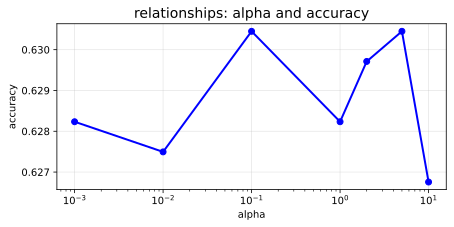

In [ ]:
alpha_values = [0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0] #alpha
accuracies = []

for alpha in alpha_values:
    model = MultinomialNB(alpha=alpha)
    model.fit(trainX_tf, trainY)
    y_pred = model.predict(testX_tf)
    acc = accuracy_score(testY,y_pred)
    accuracies.append(acc)
    print(f"alpha = {alpha:.3f}, 精度 = {acc:.4f}")

# 4. 绘制精度与alpha的关系图
plt.figure(figsize=(7, 3))
plt.plot(alpha_values, accuracies, marker='o', color='b', linestyle='-', linewidth=2)
plt.xscale('log')  # 对数刻度，便于展示大范围alpha值
plt.xlabel('alpha', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('relationships: alpha and accuracy', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

### 5. Effect of vocabulary size
The vocabulary size also affects the accuracy.  Make another plot of accuracy versus vocabulary size.  Which vocabulary size yields the best result?

In [ ]:
### INSERT YOUR CODE HERE

词汇表大小: 50, 精度: 0.4930
词汇表大小: 100, 精度: 0.5728
词汇表大小: 500, 精度: 0.6822
词汇表大小: 1000, 精度: 0.7110
词汇表大小: 5000, 精度: 0.7413
词汇表大小: 10000, 精度: 0.7295
词汇表大小: 30000, 精度: 0.7118


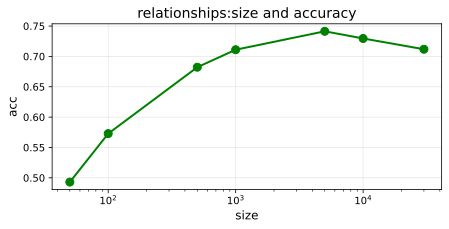

In [ ]:
vocab_sizes = [50, 100, 500, 1000, 5000, 10000,30000]
accuracies = []
for size in vocab_sizes:
    tfidf = TfidfVectorizer(max_features=size)
    
    trainX = tfidf.fit_transform(traindata)
    testX = tfidf.transform(testdata)
    
    model = MultinomialNB()
    model.fit(trainX, trainY)
    
    # 评估模型
    y_pred = model.predict(testX)
    acc = accuracy_score(testY, y_pred)
    accuracies.append(acc)
    
    print(f"词汇表大小: {size}, 精度: {acc:.4f}")

# 绘制精度与词汇表大小的关系图
plt.figure(figsize=(7, 3))
plt.plot(vocab_sizes, accuracies, marker='o', color='g', linestyle='-', linewidth=2, markersize=8)
plt.xscale('log')  # 对数刻度，适合展示大范围数值
plt.xlabel('size', fontsize=12)
plt.ylabel('acc', fontsize=12)
plt.title('relationships:size and accuracy', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

## Poisson Naive Bayes

Now we will implement a Naive Bayes classifier using a Poisson distribution to model the count of each word appearing in the document.  Recall that the Poisson distribution is:
$$ \mathrm{Poisson}(x,\mu) = \frac{1}{x!}e^{-\mu} \mu^x$$
where $x \in \{0,1,2,\cdots\}$ is a counting number, and $\mu$ is the Poisson mean (arrival rate).

Here is some code showing how to compute the Poisson distribution using scipy.

[[ -1.          -2.          -3.5       ]
 [ -1.          -1.30685282  -2.24723703]
 [ -1.69314718  -1.30685282  -1.68762124]
 [ -2.79175947  -1.71231793  -1.53347056]
 [ -4.17805383  -2.40546511  -1.66700196]
 [ -5.78749174  -3.32175584  -2.0236769 ]
 [ -7.57925121  -4.42036813  -2.5626734 ]
 [ -9.52516136  -5.6731311   -3.25582058]
 [-11.6046029   -7.05942546  -4.08249915]
 [-13.80182748  -8.56350286  -5.02696076]
 [-16.10441257 -10.17294077  -6.07678289]
 [-18.50230785 -11.87768886  -7.22191519]
 [-20.9872145  -13.66944833  -8.45405887]
 [-23.55216385 -15.54125051  -9.76624526]
 [-26.19122118 -17.48716065 -11.15253962]
 [-28.89927138 -19.50206368 -12.60782686]
 [-31.67186011 -21.58150522 -14.12765261]
 [-34.50507345 -23.72157138 -15.70810299]
 [-37.39544521 -25.91879596 -17.34571178]
 [-40.33988419 -28.17008776 -19.03738779]]


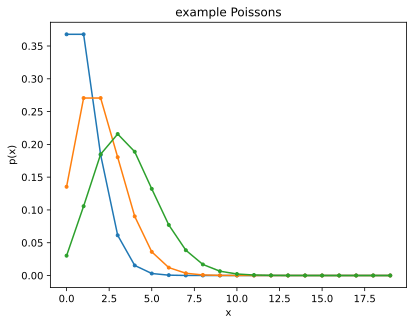

In [ ]:
#  poisson 模块:专门用于处理泊松分布（Poisson distribution） ，来自 scipy.stats 库
from scipy.stats import poisson
# arange(0,20) 生成 0 到 19 的数组，reshape((20,1)) 将其转为 20 行 1 列的列向量，作为计数 x
# mu=[[1., 2., 3.5]] 是一个 1 行 3 列的行向量，作为泊松均值 μ
# poisson.logpmf 计算给定 x 和 μ 时的对数泊松概率质量函数值，利用广播机制，列向量 x 和行向量 μ 会进行逐元素计算
px = poisson.logpmf(np.arange(0,20).reshape((20,1)), mu=[[1., 2., 3.5]])
"""
广播机制的作用
由于两个输入的形状不同（(20,1) 和 (1,3)），NumPy 会自动触发广播机制，将它们 “扩展” 为兼容的形状（(20, 3)），然后逐元素计算：
列向量 x 会被 “复制” 3 次，变成 20 行 3 列的矩阵（每行都是 [0,1,...,19]）。
行向量 mu 会被 “复制” 20 次，变成 20 行 3 列的矩阵（每列都是 [1., 2., 3.5]）。

"""
# 输出对数泊松概率质量函数值，每一列对应一个 μ 值下不同 x 的对数概率
# px 是一个二维矩阵
print(px)

# 绘制泊松分布概率质量函数的图像
# 设置图像标题为“example Poissons”
plt.title('example Poissons')
# 绘制曲线，arange(0,20) 是 x 轴数据，exp(px) 是对对数概率取指数得到的概率值，用点和线连接的形式绘制
plt.plot(np.arange(0,20), np.exp(px), '.-');
# 设置 x 轴标签为“x”
plt.xlabel('x')
# 设置 y 轴标签为“p(x)”
plt.ylabel('p(x)')
# 显示图像
plt.show()

Now let's see how to use the Poisson to create a Naive Bayes model. Let $x_i$ be the number of times the i-th word appears in the document. Then we model $x_i$ as a Poisson distribution for each class $c$,
  $$p(x_i|y=c) = \mathrm{Poisson}(x_i, \mu_{i,c})$$
where $\mu_{i, c}$ is the Poisson parameter for the i-th word in the c-th class.  Given the data $\{x_i^{(1)}, \cdots x_i^{(N)}\}$, corresponding the counts of the i-th word in the documents in the c-th class, $\mu_{i,c}$ is estimated as the mean of the data: $\mu_{i,c} = \frac{1}{N} \sum_{n=1}^N x_i^{(n)}$.

Finally, given the document $\mathbf{x} = [x_1,\cdots,x_D]$, the document class-conditional likelihood is:
  $$ p(\mathbf{x}|y=c) = \prod_{i=1}^D p(x_i|y=c) = \prod_{i=1}^D \mathrm{Poisson}(x_i, \mu_{i,c})$$
or CCD log-likelihood is
  $$ \log p(\mathbf{x}|y=c) = \sum_{i=1}^D \log \mathrm{Poisson}(x_i, \mu_{i,c})$$

Write a class for the Poisson Naive Bayes model.  Starting with the `GaussBayes` class from lecture as the template, you only need to change the estimation of the parameters $\mu_{i,c}$ and the computation of the log CCD.

In [ ]:
### INSERT YOUR CODE HERE

In [ ]:
#如果您使用 poisson.logpmf 函数遇到奇怪的错误（如“<= 和 >= 未定义”），那么问题是您将一个稀疏数组传递给该函数，该函数只能处理 ndarray。 
#使用“X.toarray（）”将稀疏数组转换为 ndarray。 
#记得把以上提示放入以下代码

In [ ]:
from scipy.stats import poisson
from scipy.special import logsumexp
import numpy as np

class PoissonBayes:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        # 获取唯一类别数量
        self.K = len(np.unique(y))
        self.mu = []       # 存储每个类别每个特征的均值
        self.pi = []       # 存储先验概率
        
        for c in range(self.K):
            # 筛选出属于当前类别c的所有样本
            # 注意：X是稀疏矩阵，需要转换为数组才能正确计算均值
            Xc = X[y == c].toarray() if hasattr(X, 'toarray') else X[y == c]
            # 计算每个特征的均值（按列计算）
            self.mu.append(np.mean(Xc, axis=0))
            # 计算先验概率
            self.pi.append(np.mean(y == c))
        
        self.pi = np.array(self.pi)

    # 计算类别c的类条件概率log p(x|y=c)的对数
    def compute_logccd(self, X, c):
        # 将稀疏矩阵转换为数组以便处理
        if hasattr(X, 'toarray'):
            X = X.toarray()
            
        lx = []
        # 获取当前类别的均值数组
        mu_c = self.mu[c]
        for i in range(X.shape[1]):
            # 获取单个特征的均值（标量）
            mu_ic = mu_c[i]
            # 获取单个特征的所有样本值
            x_i = X[:, i]
            
            # 处理均值为零的情况
            if mu_ic == 0:
                # 如果均值为零，只有当x_i为零时概率才为1
                log_p = np.where(x_i == 0, 0, -np.inf)
            else:
                # 计算泊松分布的对数概率密度
                log_p = poisson.logpmf(x_i, mu_ic)
                
            lx.append(log_p)
        
        # 对所有特征的对数概率求和
        return np.sum(lx, axis=0)
    
    # 计算联合似然/概率的对数: log p(x,y=c) = log p(x|y=c) + log p(y=c)
    # 即贝叶斯定理公式右侧的分子（联合概率）
    def compute_logjoint(self, X):
        jl = [] # 列表：每个元素是一个长度为 “样本数” 的数组（对应一个类别的联合对数概率）
        for c in range(self.K):
            jl.append(self.compute_logccd(X, c) + np.log(self.pi[c]))
        p = np.stack(jl, axis=-1)#axis=-1即多维数组里最后那一列
        #p[i, c] 表示第 i 个样本属于类别 c 的联合对数概率，即log(p(xi|y=c))
        return p
    
    # 计算每个类别给定X的后验对数概率 log p(y|x)
    def predict_logproba(self, X):
        # 计算联合对数似然 log p(x,y)
        lp = self.compute_logjoint(X)
        
        # 计算log p(x) = log （所有类别的联合概率之和）
        lpx = logsumexp(lp, axis=1)
        
        # 后验对数概率公式: log p(y|x) = log p(x,y) - log p(x)
        # lpx[:, np.newaxis]用于维度扩展，使广播运算成立
        # 广播运算：让形状不一样但 “兼容” 的数组，能自动调整成相同维度后再做计算
        return lp - lpx[:, np.newaxis]
    
    # 计算每个类别给定x的后验概率 p(y|x)
    def predict_proba(self, X):
        # 对后验对数概率取指数，转换为概率值
        return np.exp(self.predict_logproba(X))
    
    # 预测x的最可能类别
    def predict(self, X):
        # 联合对数概率矩阵：[样本数, 类别数]，例如：[-2.1, -3.2, -1.8],  样本对类别0、1、2的联合对数概率
        lp = self.compute_logjoint(X)
        # argmax(lp, axis=1)沿行方向（每个样本）找最大值的索引
        c = np.argmax(lp, axis=1)
        
        # 返回预测的类别标签
        return c
    

Now test your Poisson NB model on the Newsgroup dataset.

In [ ]:
### INSERT YOUR CODE HERE

In [ ]:
pnb=PoissonBayes()
pnb.fit(trainX,trainY)
predY = pnb.predict(testX)
acc = metrics.accuracy_score(testY, predY)
acc

0.2328159645232816

How does the Poisson NB model compare with the other models that you tested?  Is this a good model for documents?

- **INSERT YOUR ANSWER HERE**
- not a good model,it is a worse model than the models before